In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [32]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model


Load Data

In [6]:
!unzip /content/processed_images_split.zip -d /content/processed_images_split

Streaming output truncated to the last 5000 lines.
  inflating: /content/processed_images_split/processed_images_split/train/covid/COVID-19 (176).jpg  
  inflating: /content/processed_images_split/processed_images_split/train/covid/COVID-19 (177).jpg  
  inflating: /content/processed_images_split/processed_images_split/train/covid/COVID-19 (178).jpg  
  inflating: /content/processed_images_split/processed_images_split/train/covid/COVID-19 (179).jpg  
  inflating: /content/processed_images_split/processed_images_split/train/covid/COVID-19 (180).jpg  
  inflating: /content/processed_images_split/processed_images_split/train/covid/COVID-19 (181).jpg  
  inflating: /content/processed_images_split/processed_images_split/train/covid/COVID-19 (183).jpg  
  inflating: /content/processed_images_split/processed_images_split/train/covid/COVID-19 (184).jpg  
  inflating: /content/processed_images_split/processed_images_split/train/covid/COVID-19 (187).jpg  
  inflating: /content/processed_images_s

In [7]:
split_dir = '/content/processed_images_split/processed_images_split'
# Create directories for the train, validation and test sets
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')
test_dir = os.path.join(split_dir, 'test')
labels = ['pneumonia', 'normal','covid']
def load_and_preprocess_data(data_dir):
    data = []
    img_size = 224
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, (img_size, img_size))
                data.append([img_resized, class_num])
    return np.array(data, dtype=object)

# Extract the training, validation, and testing data
train_data = load_and_preprocess_data(train_dir)
val_data = load_and_preprocess_data(val_dir)
test_data = load_and_preprocess_data(test_dir)
# Separate the images and the labels
x_train, y_train = zip(*train_data)
x_val, y_val = zip(*val_data)
x_test, y_test = zip(*test_data)

# Convert the lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)



Train The Model

In [26]:
# Check TensorFlow version
print("TensorFlow version: ", tf.__version__)

# Check if TensorFlow is using GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping,learning_rate_reduction])
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

TensorFlow version:  2.16.1
Found GPU at: /device:GPU:0
Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.7514 - loss: 3.7793 - val_accuracy: 0.7721 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9000 - loss: 0.3063 - val_accuracy: 0.8900 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.9326 - loss: 0.2111 - val_accuracy: 0.6932 - val_loss: 1.1596 - learning_rate: 0.0010
Epoch 4/50
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9233 - loss: 0.2423
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9234 - loss: 0.2419 - val_accuracy: 0.6896 - val_loss: 1.7689 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9451 - loss: 0.1390 - val_accuracy: 0.9443 - val_loss: 0.1991 - learning_rate: 3.0000e-04
Epoch 6/50
130/13

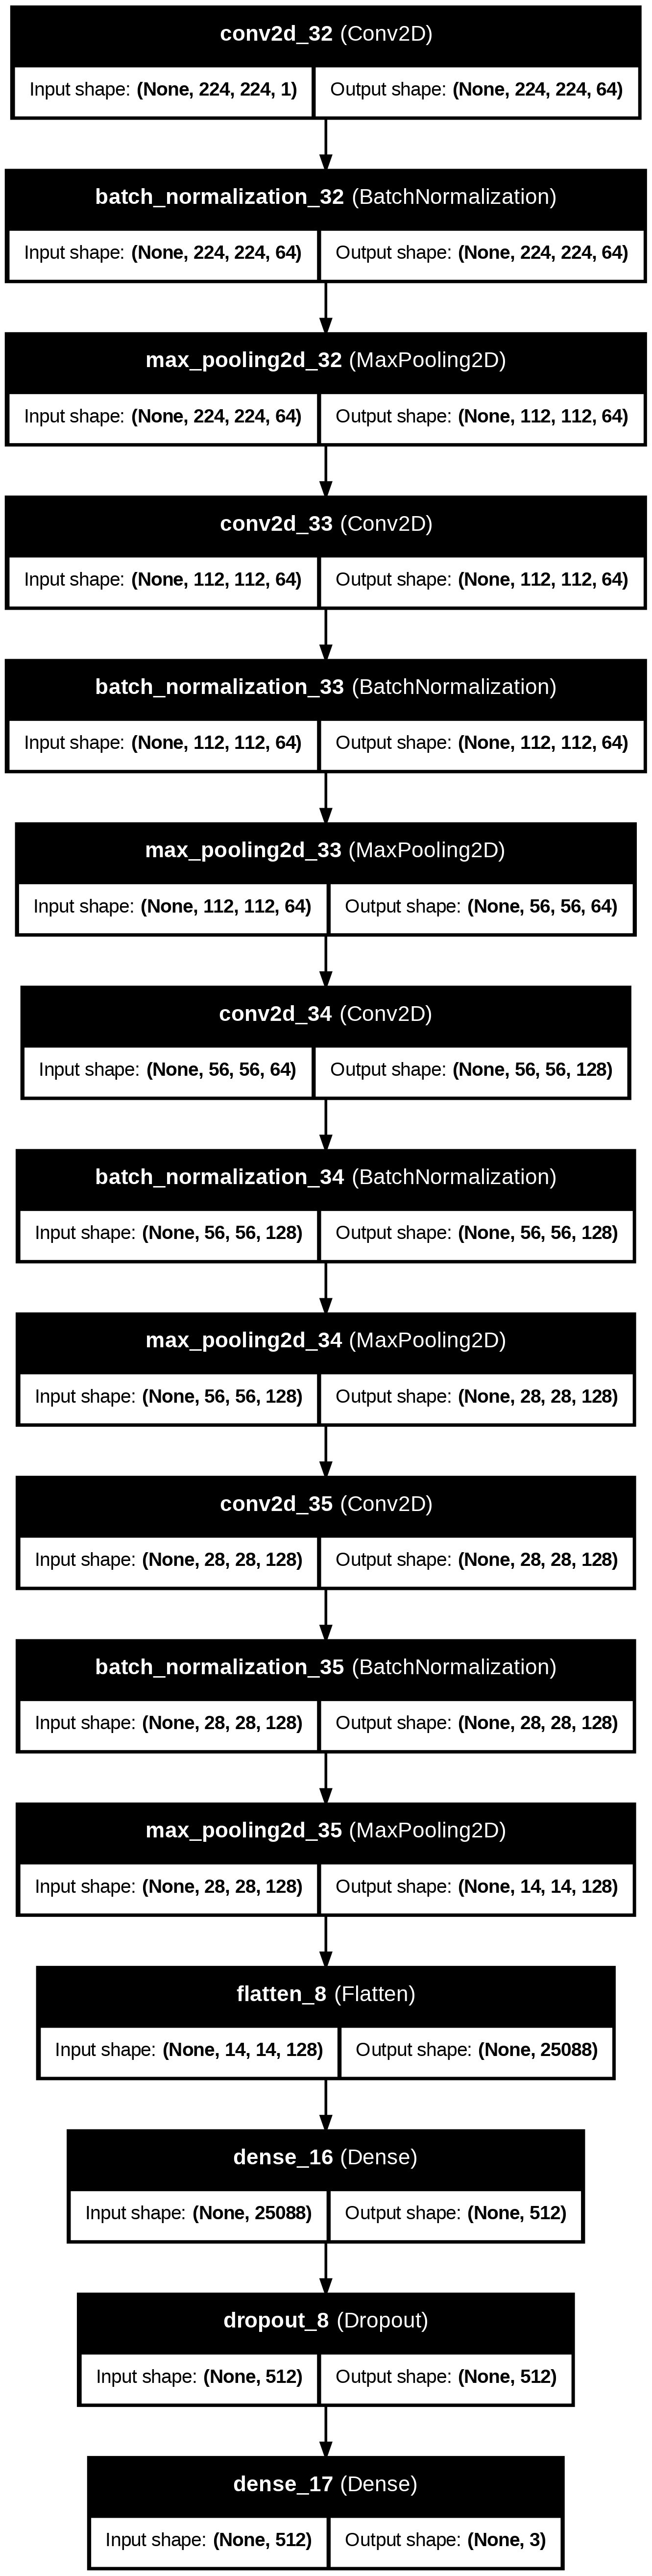

In [34]:


plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

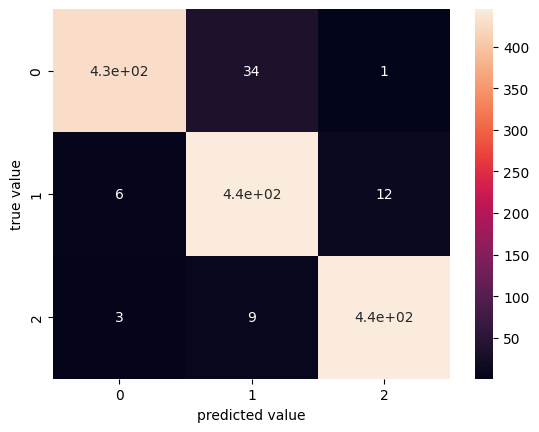

In [27]:
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm,annot=True,square=False)
plt.xlabel("predicted value")
plt.ylabel("true value")
plt.show


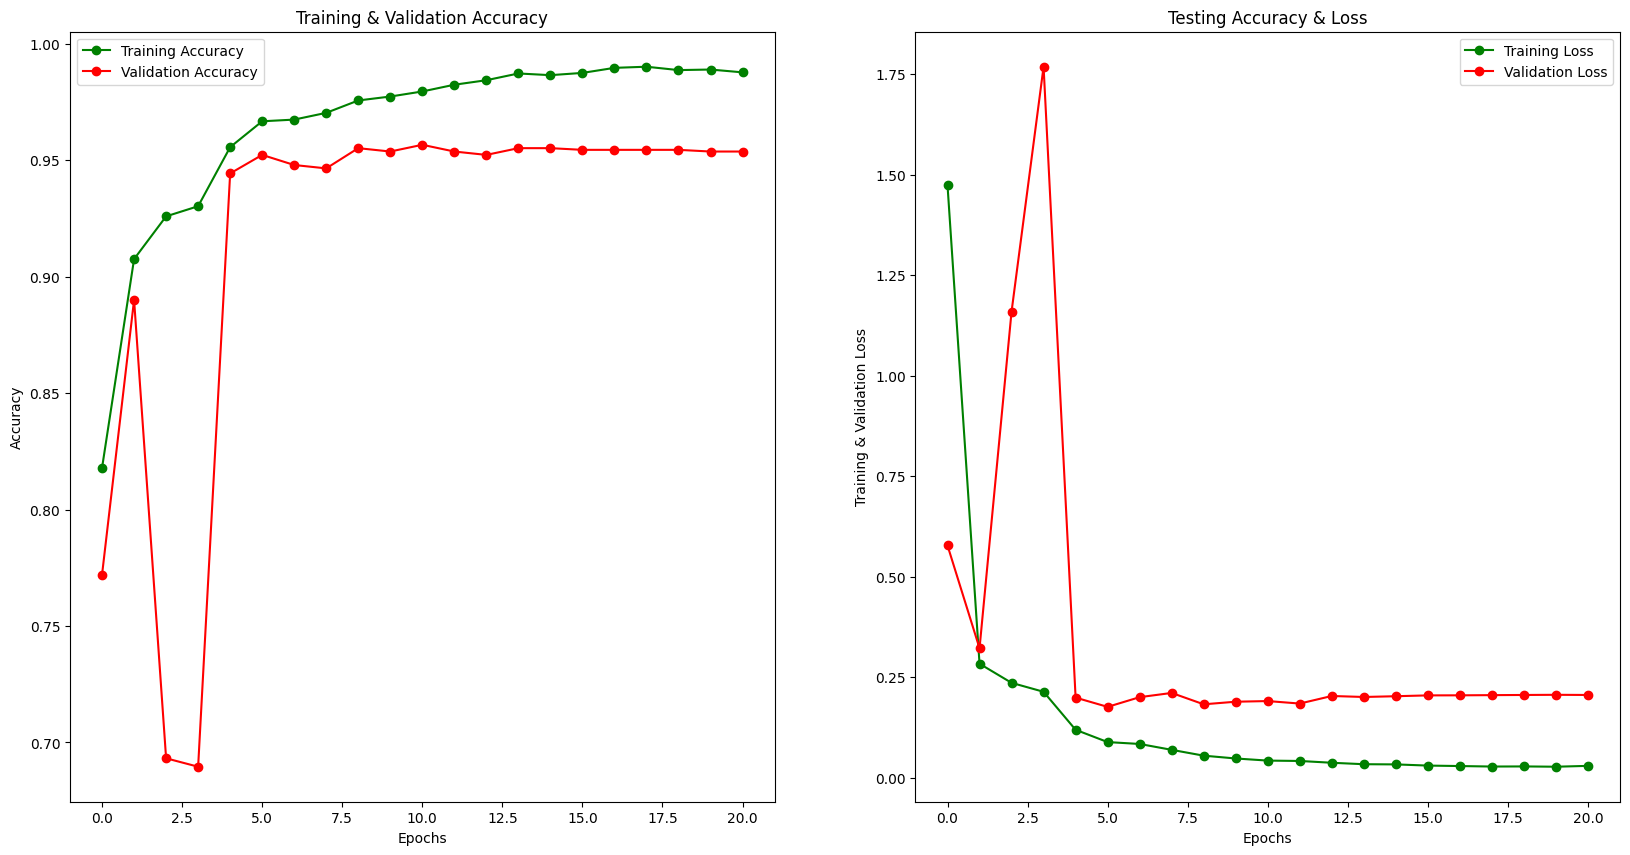

In [29]:
epochs = [i for i in range(21)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()